In [1]:
import pandas as pd
import logging
import matplotlib.pyplot as plt
import numpy as np

# create an instance of the logger
logger = logging.getLogger()

# Change current directory to parent directory
import os
os.chdir("..")

## Load the File

### Getting the 2014 Market Data

In [2]:
# Define global variables
RAW_PATH_MARKET_2014 = 'data/raw/ERCOT_Market_Data_2014.xlsx'

# Attempt to load the file with a try-except block
try:
    # Check if the file exists
    if os.path.exists(RAW_PATH_MARKET_2014):
        # Load the Excel file
        market_data_2014 = pd.ExcelFile(RAW_PATH_MARKET_2014)
        print("File loaded successfully.")
    else:
        raise FileNotFoundError(f"File not found: {RAW_PATH_MARKET_2014}")
except FileNotFoundError as fnf_error:
    print(fnf_error)
except Exception as e:
    print(f"An error occurred while reading the file: {e}")

File loaded successfully.


### Getting the 2015 Market Data

In [3]:
# Define global variables
RAW_PATH_MARKET_2015 = 'data/raw/ERCOT_Market_Data_2015.xlsx'

# Attempt to load the file with a try-except block
try:
    # Check if the file exists
    if os.path.exists(RAW_PATH_MARKET_2015):
        # Load the Excel file
        market_data_2015 = pd.ExcelFile(RAW_PATH_MARKET_2015)
        print("File loaded successfully.")
    else:
        raise FileNotFoundError(f"File not found: {RAW_PATH_MARKET_2015}")
except FileNotFoundError as fnf_error:
    print(fnf_error)
except Exception as e:
    print(f"An error occurred while reading the file: {e}")

File loaded successfully.


### Getting the SCADA DATA

In [4]:
# Define global variables
RAW_SCADA_DATA = 'data/raw/scada.csv'

# Attempt to load the file with a try-except block
try:
    # Check if the file exists
    if os.path.exists(RAW_SCADA_DATA):
        # Load the Excel file
        scada_data= pd.read_csv(RAW_SCADA_DATA)
        print("File loaded successfully.")
    else:
        raise FileNotFoundError(f"File not found: {RAW_SCADA_DATA}")
except FileNotFoundError as fnf_error:
    print(fnf_error)
except Exception as e:
    print(f"An error occurred while reading the file: {e}")

File loaded successfully.


### Adding Change in Energy as Feature for Renveue

In [5]:
# Ensure the 'WEC: Production kWh' column exists
if 'WEC: Production kWh' in scada_data.columns:
    # Calculate the energy change while handling nulls
    scada_data['Energy Change'] = scada_data['WEC: Production kWh'].fillna(method='ffill').diff()

    # Retain nulls in the new column where the original column had nulls
    scada_data.loc[scada_data['WEC: Production kWh'].isnull(), 'Energy Change'] = None
else:
    logger.error("'WEC: Production kWh' column is missing from the dataset.")

### Weekly Production Rates

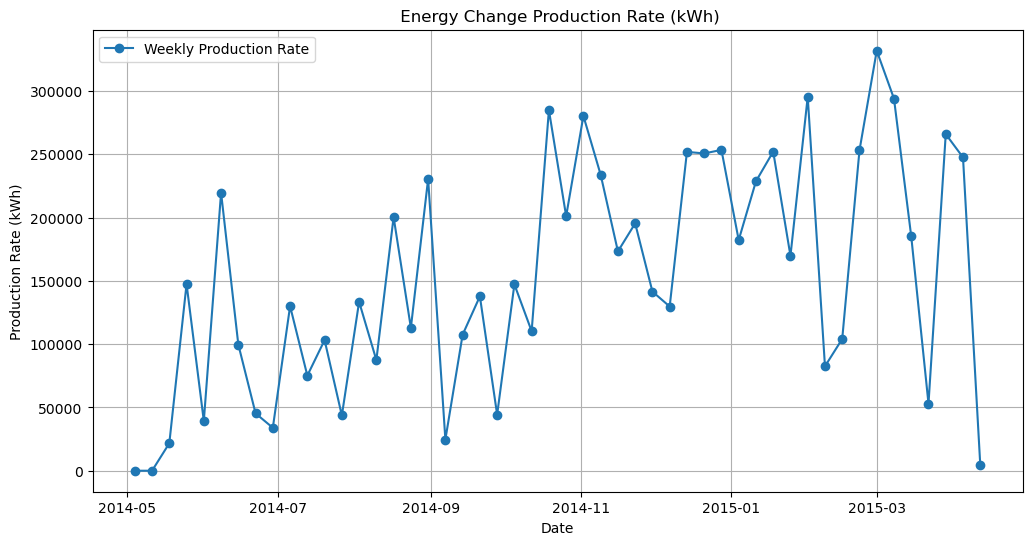

In [6]:
# Ensure the 'DateTime' column is set as the index
scada_data.set_index('DateTime', inplace=True)

# Ensure the index is in datetime format
scada_data.index = pd.to_datetime(scada_data.index, errors='coerce')


# Recalculate weekly and monthly production rates using the corrected production rate column
weekly_production_corrected = scada_data['Energy Change'].resample('W').sum()


# Plot corrected weekly production rates
plt.figure(figsize=(12, 6))
plt.plot(weekly_production_corrected.index, weekly_production_corrected.values, label='Weekly Production Rate', marker='o')
plt.title(' Energy Change Production Rate (kWh)')
plt.xlabel('Date')
plt.ylabel('Production Rate (kWh)')
plt.grid(True)
plt.legend()
plt.show()



### Monthly Production Rates

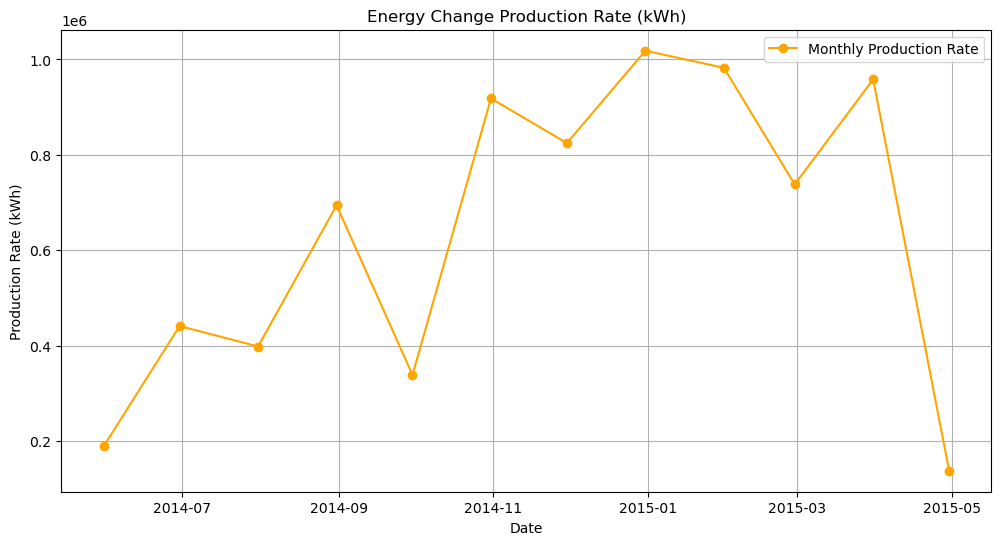

In [7]:

# Recalculate weekly and monthly production rates using the corrected production rate column
monthly_production_corrected = scada_data['Energy Change'].resample('M').sum()


# Plot corrected monthly production rates
plt.figure(figsize=(12, 6))
plt.plot(monthly_production_corrected.index, monthly_production_corrected.values, label='Monthly Production Rate', marker='o', color='orange')
plt.title('Energy Change Production Rate (kWh)')
plt.xlabel('Date')
plt.ylabel('Production Rate (kWh)')
plt.grid(True)
plt.legend()
plt.show()

### Using the market data of 2014 and 2015 to determine hourly settment price by the hour

1. Combine Delivery Date and Hour Ending from each ERCOT market sheet into a datetime format.
2. Aggregate hourly settlement point prices across all hubs for each ERCOT sheet.
3. Merge SCADA data with ERCOT market data by matching datetime (to the hour).
4. Add a feature for settlement point price by hour and calculate revenue. 

In [8]:
# Enhanced processing function to handle single 'Settlement Point Price' column per 'DateTime'
def process_market_data_grouped(market_data):
    processed_sheets = []
    for sheet in market_data.sheet_names:
        try:
            df = market_data.parse(sheet)
            # Check for required columns
            if {'Delivery Date', 'Hour Ending', 'Settlement Point Price'}.issubset(df.columns):
                # Convert Delivery Date to datetime
                df['Delivery Date'] = pd.to_datetime(df['Delivery Date'], errors='coerce')
                # Parse Hour Ending and calculate hours
                df['Hour Ending'] = df['Hour Ending'].str.extract(r'(\d+)').astype(float) - 1
                # Create complete DateTime column
                df['DateTime'] = df['Delivery Date'] + pd.to_timedelta(df['Hour Ending'], unit='h')
                # Group by DateTime and average the settlement point prices
                grouped = df.groupby('DateTime')['Settlement Point Price'].mean().reset_index()
                processed_sheets.append(grouped)
            else:
                print(f"Missing required columns in sheet: {sheet}")
        except Exception as e:
            print(f"Error processing sheet {sheet}: {e}")
    return pd.concat(processed_sheets, ignore_index=True) if processed_sheets else pd.DataFrame()

# Reprocess ERCOT 2014 and 2015 market data with the updated function
market_2014_grouped = process_market_data_grouped(market_data_2014)
market_2015_grouped = process_market_data_grouped(market_data_2015)

# Combine the processed data for both years
market_combined_grouped = pd.concat([market_2014_grouped, market_2015_grouped])

# Inspect the resulting DataFrame
market_combined_grouped.head()


,DateTime,Settlement Point Price
0,2014-01-01 00:00:00,28.129286
1,2014-01-01 01:00:00,25.040000
2,2014-01-01 02:00:00,24.903571
3,2014-01-01 03:00:00,24.905000
4,2014-01-01 04:00:00,25.053571


### Calculate Revenue: Multiply Energy Change from SCADA data with Settlement Point Price

1. Round SCADA and Market Datetimes to the Hour: Standardize DateTime precision to the nearest hour.
2. Merge: Attempt to align the datasets after adjusting for precision.
3. Calculate revenue by multiplying Energy Change from SCADA data with the Settlement Point Price.

In [9]:
# Ensure both datasets have DateTime as the index for merging
market_combined_grouped.set_index('DateTime', inplace=True)
scada_data.index = scada_data.index.round('H')  # Ensure SCADA DateTime is rounded to the hour

# Merge SCADA data with market data
scada_with_prices = scada_data.join(market_combined_grouped, how='inner')

# Calculate revenue
scada_with_prices['Revenue'] = scada_with_prices['Energy Change'] * scada_with_prices['Settlement Point Price']

# Display a preview of the merged data with revenue
scada_with_prices[['Energy Change', 'Settlement Point Price', 'Revenue']].dropna().head()


,Energy Change,Settlement Point Price,Revenue
DateTime,,,
2014-05-01 00:00:00,0.0,34.062857,0.0
2014-05-01 00:00:00,0.0,34.062857,0.0
2014-05-01 00:00:00,0.0,34.062857,0.0
2014-05-01 01:00:00,0.0,29.691429,0.0
2014-05-01 01:00:00,0.0,29.691429,0.0


### Aggregate revenue on a weekly basis 

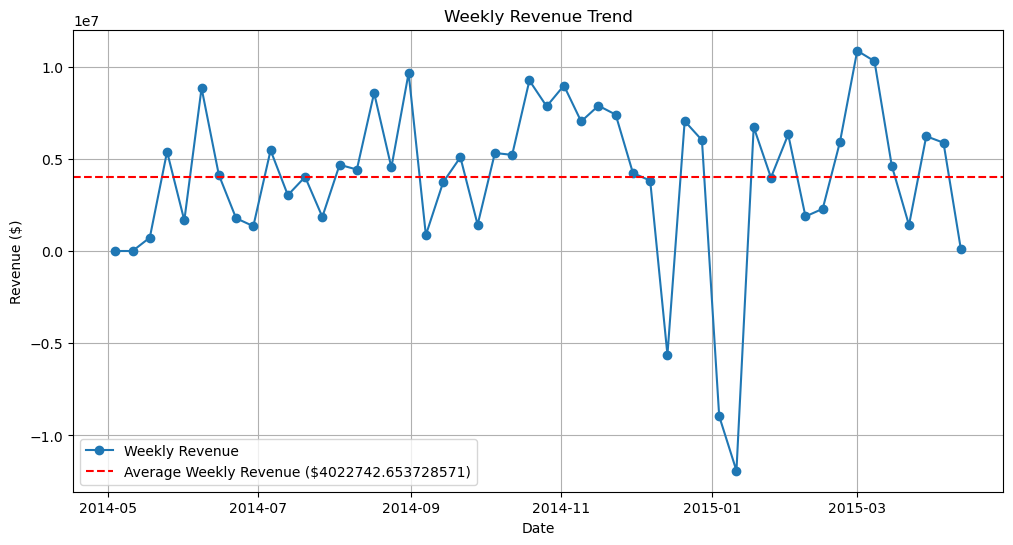

In [10]:

# Aggregate revenue on a weekly basis
weekly_revenue = scada_with_prices['Revenue'].resample('W').sum()

# Define a mean threshold for weekly revenue
avg_threshold_w = weekly_revenue.values.mean() 

# Plot weekly revenue
plt.figure(figsize=(12, 6))
plt.plot(weekly_revenue.index, weekly_revenue.values, label='Weekly Revenue', marker='o')
plt.axhline(y=avg_threshold_w, color='red', linestyle='--', label=f'Average Weekly Revenue (${avg_threshold_w})')
plt.title('Weekly Revenue Trend')
plt.xlabel('Date')
plt.ylabel('Revenue ($)')
plt.grid(True)
plt.legend()
plt.show()



### Aggregate revenue on a monthly basis 

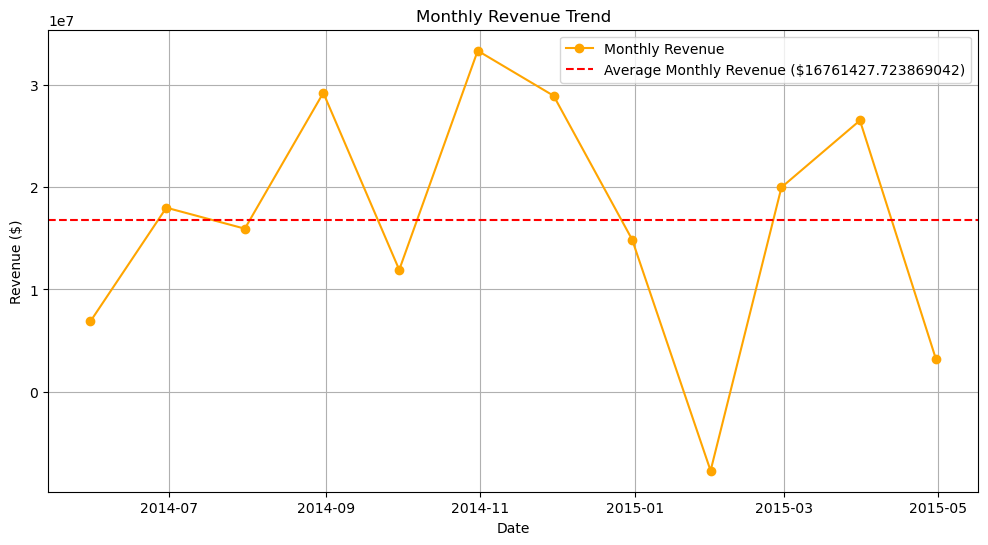

In [11]:
# Aggregate revenue on a monthly basis
monthly_revenue = scada_with_prices['Revenue'].resample('M').sum()

# Define a mean threshold for monthly revenue
avg_threshold_m = monthly_revenue.values.mean()

# Plot monthly revenue
plt.figure(figsize=(12, 6))
plt.plot(monthly_revenue.index, monthly_revenue.values, label='Monthly Revenue', marker='o', color='orange')
plt.axhline(y=avg_threshold_m, color='red', linestyle='--', label=f'Average Monthly Revenue (${avg_threshold_m})')
plt.title('Monthly Revenue Trend')
plt.xlabel('Date')
plt.ylabel('Revenue ($)')
plt.grid(True)
plt.legend()
plt.show()

## Adding Revenue as Feature to the merged data